In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import dalex as dx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

In [5]:
#df_modelos = pd.read_csv("data/datosFinales/df_modelos.csv", sep = ";")
df_modelos = pd.read_csv("../data/datosFinales/diferencias_2.csv", sep = ";")

#dropped columns which are 0
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.contains('diferencia_')]
categoricas = pd.read_csv("../data/categoricas.csv", sep = ",").squeeze().tolist()
print(len(categoricas))
#remove columns with many NAs
categoricas.remove('tipo_plastia')
categoricas.remove('via_asc_plastia')
print(len(categoricas))

30
28


In [6]:
df_modelos

,id_registro,sexo,edad,peso,talla,imc,neoadyuvancia,localizacion,tipo_histologico,ct,...,sat_oxig_diferencia2_5,temp_corp_diferencia2_5,frec_resp_diferencia2_5,neutrofilos_diferencia2_5,frec_card_diferencia2_5,linfocitos_diferencia2_5,eva_diferencia2_5,plaquetas_diferencia2_5,albumina_diferencia2_5,pcr_diferencia2_5
0,92-1,0.0,61.0,79.0,178.0,24.9,1.0,4.0,1.0,4.0,...,1.0,-0.2,-1.0,-0.528656,NaN,NaN,-2.0,0.206335,-0.9,-14.60
1,92-2,1.0,79.0,95.0,170.0,32.9,0.0,4.0,1.0,2.0,...,-1.0,-0.7,-8.0,0.025972,26.0,NaN,-2.0,0.423668,0.7,-7.70
2,92-3,0.0,74.0,94.0,175.0,30.7,1.0,4.0,NaN,4.0,...,-2.0,0.5,1.0,-0.316932,22.0,NaN,2.0,0.015873,0.2,113.60
3,92-4,0.0,74.0,63.0,168.0,22.3,2.0,3.0,1.0,5.0,...,-13.0,1.5,2.0,NaN,20.0,NaN,4.0,NaN,NaN,NaN
4,92-5,0.0,62.0,57.0,157.0,23.1,2.0,4.0,1.0,4.0,...,-3.0,0.2,0.0,0.961284,7.0,NaN,-2.0,-0.081526,0.8,-165.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,613-30,0.0,72.0,83.0,169.0,29.1,1.0,3.0,1.0,3.0,...,-1.0,-0.3,-1.0,-0.234513,-12.0,-0.495879,-1.0,0.096331,NaN,24.91
724,613-31,1.0,40.0,58.0,160.0,22.7,0.0,5.0,1.0,3.0,...,0.0,-0.2,-2.0,-0.109463,-11.0,-0.743461,-3.0,0.373588,NaN,7.88
725,613-32,0.0,59.0,82.0,171.0,28.0,1.0,7.0,1.0,2.0,...,0.0,-1.7,-7.0,-0.198163,-22.0,0.328282,-2.0,0.518792,NaN,-5.73
726,617-1,0.0,74.0,53.0,160.0,20.7,0.0,6.0,2.0,2.0,...,-1.0,-0.5,-2.0,-0.753551,-22.0,NaN,-2.0,0.289890,NaN,-174.00


In [7]:
idPats = np.unique(df_modelos.id_registro)

df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_5')]
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_4')]
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_3')]
#df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_2')]

# Modelo Xgboost


In [8]:
np.random.seed(14)

In [9]:
df_tmp = df_modelos.copy()[df_modelos['fuga'] != -1]
cats = []

# label_encoder = LabelEncoder()
# for col in categoricas:
#     if col in df_tmp.columns:
#         df_tmp[col] = label_encoder.fit_transform(df_tmp[col])
#         cats.append(col)
    
columnas_a_eliminar = [col for col in df_tmp.columns if "fuga" in col]
X = df_tmp.drop(columnas_a_eliminar, axis=1)
X = X.drop(['id_registro'], axis=1)

y = df_tmp['fuga']

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
# Instanciar el codificador
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Ajustar y transformar las columnas categóricas
X_cat_encoded = encoder.fit_transform(X[cats])

# Crear DataFrame con los nuevos nombres de columnas
cat_encoded_df = pd.DataFrame(
    X_cat_encoded,
    columns=encoder.get_feature_names_out(cats),
    index=X.index  # mantener los índices originales
)

# Concatenar con el resto de columnas no categóricas
X_encoded = pd.concat([X.drop(columns=cats), cat_encoded_df], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, stratify=y, random_state=14)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=14)

In [13]:
from sklearn.metrics import accuracy_score, f1_score

In [14]:
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': ['auc', 'error'],
    'max_depth': 4,  # Reducida desde 5
    'learning_rate': 0.001,  # Reducida desde 0.05
    'subsample': 0.3,  # Más bajo para más regularización
    'colsample_bytree': 0.7,
    'min_child_weight': 5,  # Aumentada desde 3
    'gamma': 0.3,  # Aumentada desde 0.2
    'reg_alpha': 2,  # Aumentada desde 1
    'reg_lambda': 15,  # Aumentada desde 10
    'scale_pos_weight': len(y_train[y_train==0])/len(y_train[y_train==1]) * 1.2,  # Balance ajustado
    'seed': 14,
    'tree_method': 'hist'
}

# Encode categorical variables in X_train and X_val
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Convertir a DMatrix

dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dtest = xgb.DMatrix(X_test_encoded)


#evals_result = {}
model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=2000,  # Más iteraciones posibles
    verbose_eval=50
)

y_proba_train = model.predict(dtrain)
y_pred_train = (y_proba_train >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TRAIN:")
print(confusion_matrix(y_train, y_pred_train))
print("\nReporte de clasificación TRAIN:")
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train, y_pred_train)
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_train, y_pred_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("F1 score:", f1)


y_proba_test = model.predict(dtest)
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_test))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_test))
#auc
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba_test)
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_test, y_pred_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 score:", f1)


=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TRAIN:
[[325  57]
 [ 10  82]]

Reporte de clasificación TRAIN:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       382
           1       0.59      0.89      0.71        92

    accuracy                           0.86       474
   macro avg       0.78      0.87      0.81       474
weighted avg       0.90      0.86      0.87       474

AUC: 0.8710
Accuracy: 0.8586497890295358
F1 score: 0.70995670995671

=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TEST:
[[118  47]
 [ 12  27]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       165
           1       0.36      0.69      0.48        39

    accuracy                           0.71       204
   macro avg       0.64      0.70      0.64       204
weighted avg       0.80      0.71    

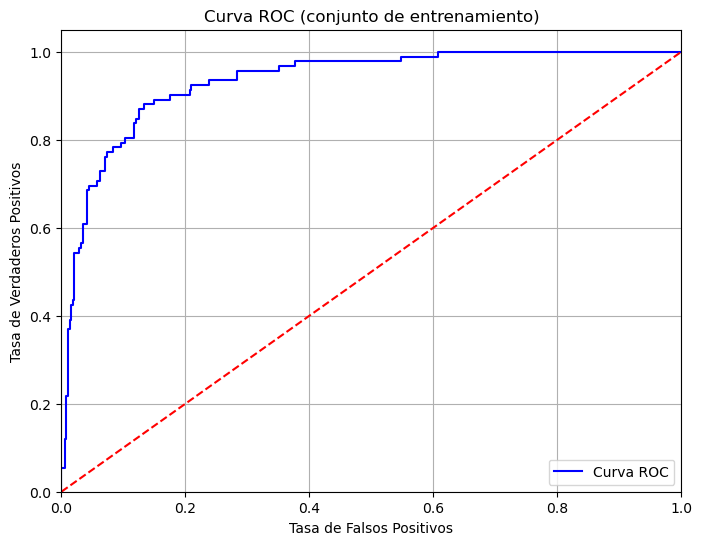

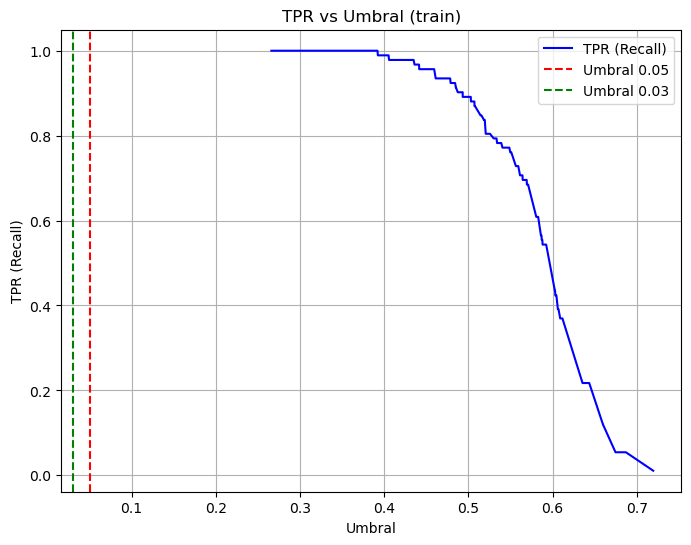

In [ ]:
#show the roc curve for the model "modelo_hgb"
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt


fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_proba_train, pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de entrenamiento)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el tpr vs el umbral para train
plt.figure(figsize=(8, 6))
plt.plot(thresholds_train, tpr_train, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral (train)')
plt.legend()
plt.grid()
plt.show()


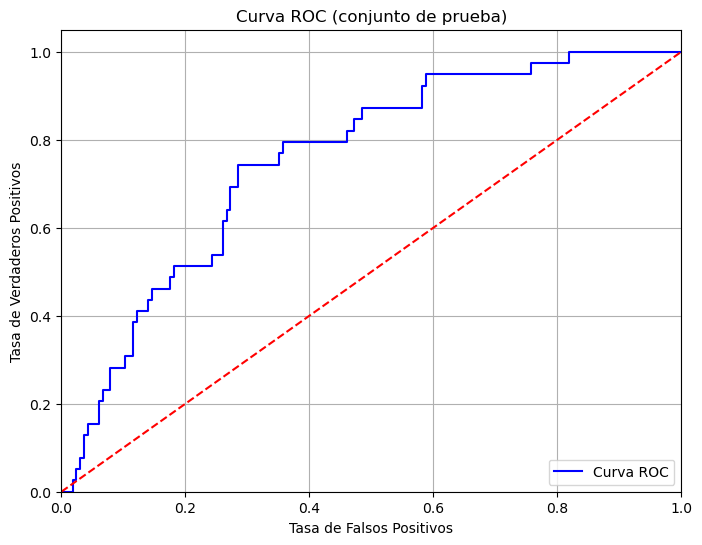

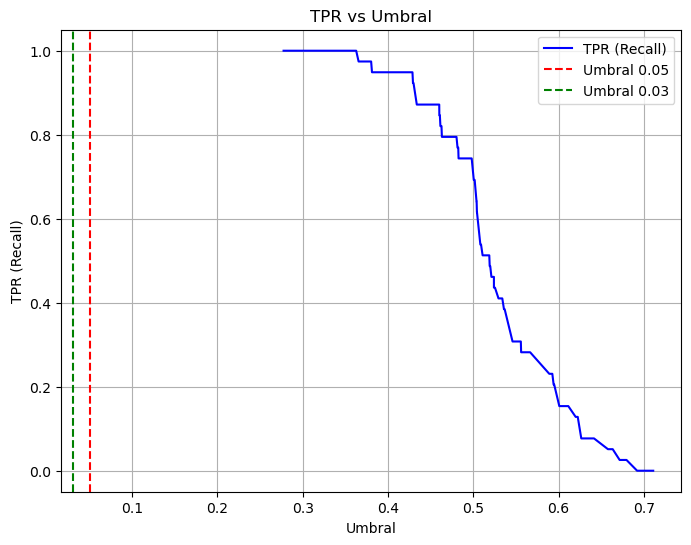

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_test, pos_label=1)
#graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de prueba)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el fpr vs el umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.axvline(x=0.03, color='green', linestyle='--', label='Umbral 0.03')
plt.legend()
plt.grid()
plt.show()


In [17]:

exp = dx.Explainer(model, X, y)
vi = exp.model_parts()
vi.plot(max_vars=20)
#select the 10 most important variables from the explainer
imps = vi.result['variable'][-30:-1].tolist()
imps.append('id_registro')

Preparation of a new explainer is initiated

  -> data              : 678 rows 139 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 678 values
  -> model_class       : xgboost.core.Booster (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_xgboost at 0x1485f6ef0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.266, mean = 0.456, max = 0.719
  -> model type        : 'model_type' not provided and cannot be extracted.
  -> model type        : Some functionalities won't be available.
  -> residual function : difference between y and yhat (default)


  -> residuals         : min = -0.711, mean = -0.263, max = 0.637
  -> model_info        : package xgboost

A new explainer has been created!


In [19]:
df_imps = df_modelos[imps]
df_imps['fuga'] = df_modelos['fuga']
df_imps['id_registro'] = df_modelos['id_registro']

In [20]:
df_tmp = df_imps.copy()[df_imps['fuga'] != -1]
cats = []
    
columnas_a_eliminar = [col for col in df_tmp.columns if "fuga" in col]
X = df_tmp.drop(columnas_a_eliminar, axis=1)
X = X.drop(['id_registro'], axis=1)
y = df_tmp['fuga']



In [21]:
# for col in cats:
#     if col in X.columns:
#         label_encoder = LabelEncoder()  
#         label_encoder.fit(X[col]) 
#         X[col] = label_encoder.transform(X[col])

# X_trainval, X_test, y_trainval, y_test = train_test_split(
#     X, y, 
#     test_size=0.3, 
#     stratify=y, 
#     random_state=14
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_trainval, y_trainval, 
#     test_size=0.2, 
#     stratify=y_trainval, 
#     random_state=14
# )

In [22]:
from hyperopt import fmin, tpe, hp, Trials

# Definir espacio de búsqueda
space = {
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.1)),
    'subsample': hp.uniform('subsample', 0.6, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.9),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 20),
    'min_child_weight': hp.quniform('min_child_weight', 1, 15, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 5)
}

def objective(params):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'gamma': params['gamma'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'min_child_weight': params['min_child_weight'],
        'scale_pos_weight': params['scale_pos_weight'],
        'seed': 14,
        'tree_method': 'hist'
    }
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=500,
        nfold=5,
        stratified=True,
        early_stopping_rounds=50,
        verbose_eval=False,
        seed=14  # Establecer la semilla de aleatoriedad
    )
    
    return -cv_results['test-auc-mean'].max()  # Maximizar AUC

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

100%|██████████| 50/50 [03:17<00:00,  3.95s/trial, best loss: -0.7689247041047595]


In [23]:
best

{'colsample_bytree': 0.8563288853565717,
 'gamma': 0.010657737689215185,
 'learning_rate': 0.03858901543596754,
 'max_depth': 5.0,
 'min_child_weight': 10.0,
 'reg_alpha': 7.59251048245493,
 'reg_lambda': 5.923389819076605,
 'scale_pos_weight': 2.1281247597290744,
 'subsample': 0.8702752864956721}

In [24]:
from sklearn.metrics import f1_score, accuracy_score

In [25]:
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': ['auc', 'error'],
    'max_depth': int(best['max_depth']),  # Hyperopt devuelve float, necesitamos int
    'learning_rate': best['learning_rate'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_child_weight': best['min_child_weight'],
    'scale_pos_weight': best['scale_pos_weight'],
    'seed': 14,
    'tree_method': 'hist',
}


# Encode categorical variables in X_train and X_val
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
# for col in cats:
#     if col in X_train_encoded.columns:
#         # Fit the LabelEncoder on the combined data of train, val, and test
#         combined_data = pd.concat([X_train_encoded[col], X_test_encoded[col]])#, X_val_encoded[col]])
#         label_encoder.fit(combined_data)
    
#         # Transform the data
#         X_train_encoded[col] = label_encoder.transform(X_train_encoded[col])
#         X_test_encoded[col] = label_encoder.transform(X_test_encoded[col])
# Convertir a DMatrix

dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dtest = xgb.DMatrix(X_test_encoded)


#evals_result = {}
model2 = xgb.train(
    best_params,
    dtrain,
    num_boost_round=2000,  # Más iteraciones posibles
    verbose_eval=50
)

y_proba_train = model2.predict(dtrain)
y_pred_train = (y_proba_train >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TRAIN:")
print(confusion_matrix(y_train, y_pred_train))
print("\nReporte de clasificación TRAIN:")
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train, y_pred_train)
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_train, y_pred_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("F1 score:", f1)


y_proba_test = model2.predict(dtest)
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_test))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_test))
#auc
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba_test)
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_test, y_pred_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 score:", f1)


=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TRAIN:
[[380   2]
 [  3  89]]

Reporte de clasificación TRAIN:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       382
           1       0.98      0.97      0.97        92

    accuracy                           0.99       474
   macro avg       0.99      0.98      0.98       474
weighted avg       0.99      0.99      0.99       474

AUC: 0.9811
Accuracy: 0.989451476793249
F1 score: 0.9726775956284153

=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TEST:
[[151  14]
 [ 29  10]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       165
           1       0.42      0.26      0.32        39

    accuracy                           0.79       204
   macro avg       0.63      0.59      0.60       204
weighted avg       0.76      0.79   

In [26]:
exp = dx.Explainer(model2, X_encoded, y)
vi = exp.model_parts()
vi.plot(max_vars=20)


Preparation of a new explainer is initiated

  -> data              : 678 rows 139 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 678 values
  -> model_class       : xgboost.core.Booster (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_xgboost at 0x1485f6ef0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00876, mean = 0.247, max = 0.949
  -> model type        : 'model_type' not provided and cannot be extracted.
  -> model type        : Some functionalities won't be available.
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.949, mean = -0.0536, max = 0.953
  -> model_info        : package xgboost

A new explainer has been created!


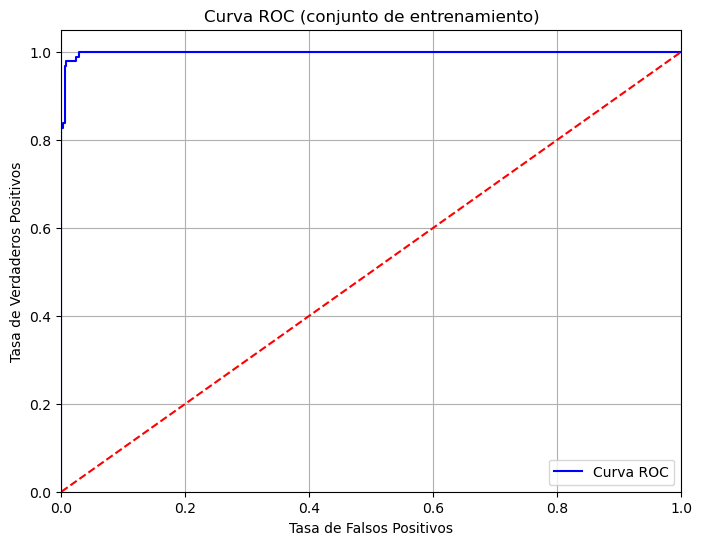

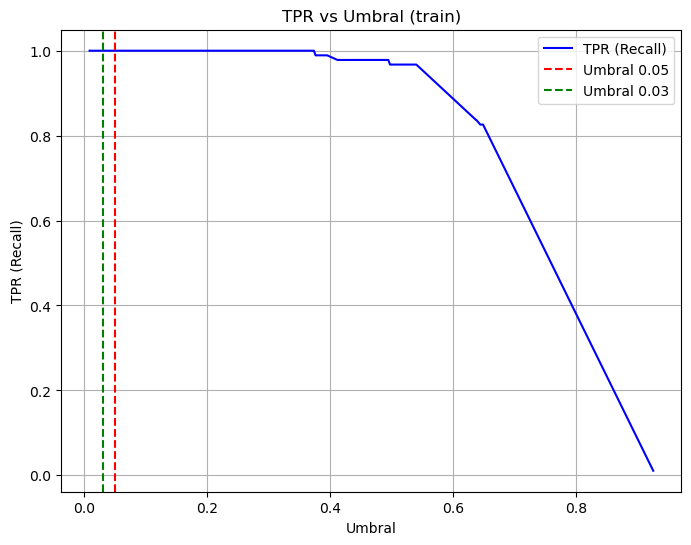

In [27]:
#show the roc curve for the model "modelo_hgb"
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt


fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_proba_train, pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de entrenamiento)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el tpr vs el umbral para train
plt.figure(figsize=(8, 6))
plt.plot(thresholds_train, tpr_train, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral (train)')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.axvline(x=0.03, color='green', linestyle='--', label='Umbral 0.03')
plt.legend()
plt.grid()
plt.show()

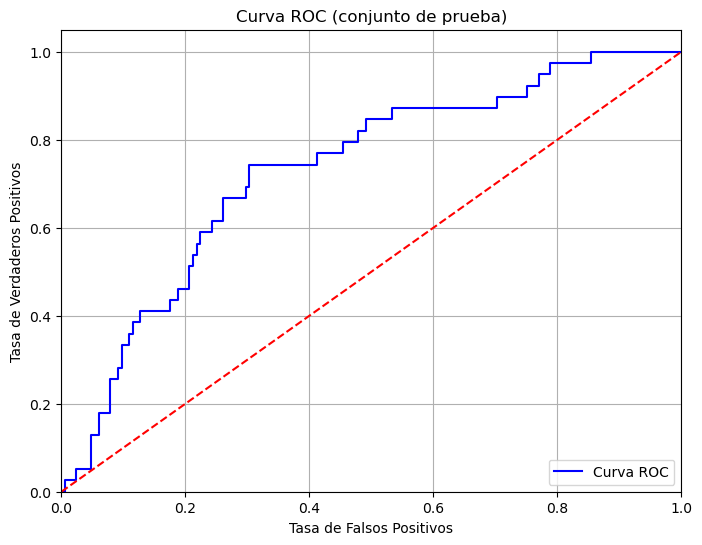

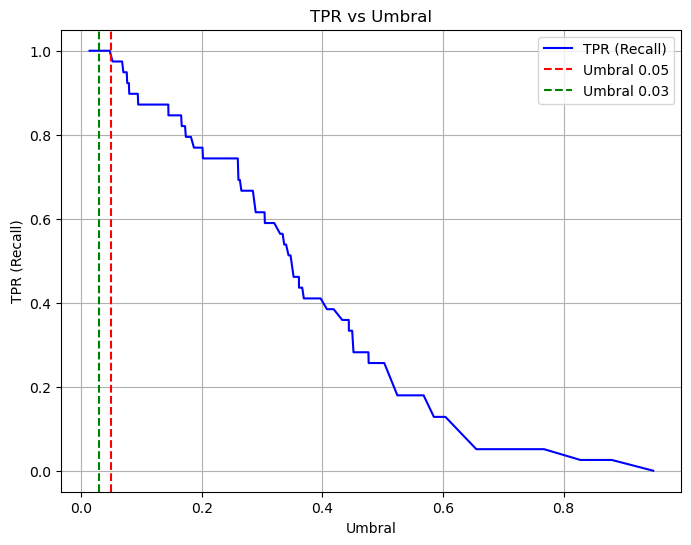

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_test, pos_label=1)
#graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de prueba)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el fpr vs el umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.axvline(x=0.03, color='green', linestyle='--', label='Umbral 0.03')
plt.legend()
plt.grid()
plt.show()


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,
    n_estimators=100
)

rf.fit(X_train, y_train)

ensemble_pred = (0.7*y_proba_test + 0.3*rf.predict_proba(X_test)[:,1]) > 0.39
y_pred_ensemble = ensemble_pred.astype(int)

# Generar reporte de clasificación completo
print("\n=== RESULTADOS DEL ENSEMBLE ===")
print("Matriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_ensemble))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_ensemble, zero_division=0))
print(f"AUC-ROC Ensemble: {roc_auc_score(y_test, 0.7*y_proba_test + 0.3*rf.predict_proba(X_test)[:,1]):.4f}")


=== RESULTADOS DEL ENSEMBLE ===
Matriz de confusión TEST:
[[140  25]
 [ 23  16]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       165
           1       0.39      0.41      0.40        39

    accuracy                           0.76       204
   macro avg       0.62      0.63      0.63       204
weighted avg       0.77      0.76      0.77       204

AUC-ROC Ensemble: 0.7403


In [30]:
#0.7158